In [163]:
import numpy as np
import cv2

def mutual_information(image1, image2, bins=256):
    # Calculate the histogram of the images, 这个hist_2d对应的z值是(intensity_1(image1的), intensity_2(image2的))对应出现的频率
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)

    # Calculate the joint probability distribution
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # Marginal for x over y
    py = np.sum(pxy, axis=0) # Marginal for y over x

    # Calculate the mutual information
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Non-zero joint probabilities
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    return mi

def calculate_entropy(hist):
    """根据直方图计算熵"""
    p = hist / hist.sum()
    p = p[p > 0] # 移除概率为0的项
    return -np.sum(p * np.log2(p))

def normalized_mutual_information(image1, image2, bins=256):
    """计算归一化互信息（NMI）。"""
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)

    # 计算边缘熵
    h1, _ = np.histogram(image1, bins=bins)
    h2, _ = np.histogram(image2, bins=bins)
    h1_entropy = calculate_entropy(h1)
    h2_entropy = calculate_entropy(h2)

    # 计算联合熵
    h12_entropy = calculate_entropy(hist_2d)

    # 计算 NMI
    nmi = (h1_entropy + h2_entropy) / h12_entropy
    return nmi


In [3]:
bse_img = cv2.imread('multimodal/bse.bmp', cv2.IMREAD_GRAYSCALE)
ct_img = cv2.imread('multimodal/ct.bmp', cv2.IMREAD_GRAYSCALE)
ct_2_img = cv2.imread('multimodal/ct-2.bmp', cv2.IMREAD_GRAYSCALE)
ct_3_img = cv2.imread('multimodal/ct-3.bmp', cv2.IMREAD_GRAYSCALE)

print(f"mi-right: {mutual_information(bse_img, ct_img)}")
print(f"mi-not-right-1: {mutual_information(bse_img, ct_2_img)}")
print(f"mi-not-right-2: {mutual_information(bse_img, ct_3_img)}")
print(f"mi-ct: {mutual_information(ct_2_img, ct_3_img)}")

mi-right: 0.2681261290311534
mi-not-right-1: 0.19244017699905164
mi-not-right-2: 0.18917684909006333
mi-ct: 0.236912871342073


MI: 0.2107178773321993
NMI: 1.0222886653308416
h_floated_entropy: 6.278282076136957
h_cropped_entropy: 7.665012543805318
h_AB: 13.639292983288463


(<Axes: title={'center': 'transform_origin'}>,
 Text(0.5, 1.0, 'transform_origin'))

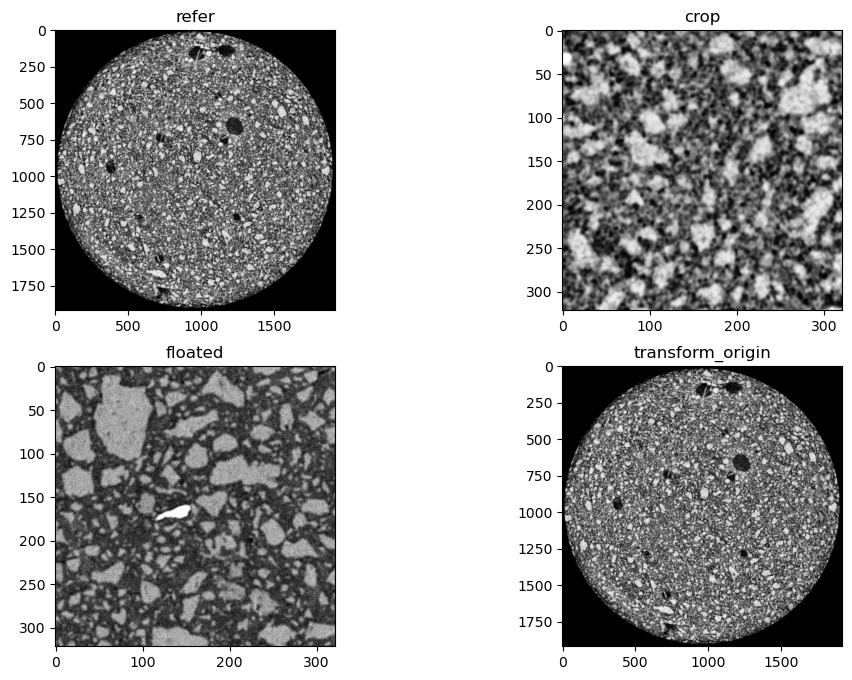

In [205]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def crop_rotate(image, center, size, angle):
    """
    Crop and rotate a region from an image.

    :param image: Source image
    :param center: Tuple (x, y) - the center of the region to crop
    :param size: Tuple (width, height) - the size of the region to crop
    :param angle: Rotation angle in degrees
    :return: Cropped and rotated image region
    """

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Perform rotation
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    # Calculate the coordinates of the top-left corner of the cropped region
    x = int(center[0] - size[0] / 2)
    y = int(center[1] - size[1] / 2)

    # Crop the region
    # 防止出现超出数组范围的情况

    # Define row and column ranges
    start_row, end_row = y, y + size[1]  # Example row range
    start_col, end_col = x, x + size[0]  # Example column range

    # Define the fill value for out-of-bounds indices
    fill_value = 0.0

    # 对超出区域的处理
    cropped = [[rotated[i][j] if i >= 0 and i < len(rotated) and j >= 0 and j < len(rotated[i]) else fill_value 
          for j in range(start_col, end_col)] 
         for i in range(start_row, end_row)]

    return cropped, rotated

# Load the images
refered_img = cv2.imread('multimodal/slice_19_ct_contrast.bmp', cv2.IMREAD_GRAYSCALE)
floated_img = cv2.imread('multimodal/slice_bse_rect_mini.bmp', cv2.IMREAD_GRAYSCALE)


width, height = refered_img.shape

floated_width, floated_height = floated_img.shape

x_delta = 1000
y_delta = 1000

interval = 100

# 生成 x 和 y 的坐标点
x = np.arange(-x_delta, x_delta+interval, interval)
y = np.arange(-y_delta, y_delta+interval, interval)

# 生成坐标点网格
xx, yy = np.meshgrid(x, y)

mi_datas = []
nmi_datas = []

# Specify center, size, and angle
# center = (220, 155)  # BEST POSITION Example center position (x, y)
center = (1210, 1101.2218) #(1160, 1869) #(1060, 969)##(1210, 1101.2218) ## (100, 900) # (400, 359)
size = (floated_height, floated_width)      # Example size (width, height)
angle = 0           # Example rotation angle in degrees
csv_prefix = "after_contrast_"

# 生成坐标点的列表
# coordinates = np.vstack([xx.ravel(), yy.ravel()]).T
# for i, coord in enumerate(coordinates):
#     coordinate = coord.tolist()
#     p = (center[0] + coordinate[0], center[1] + coordinate[1])

#     # Crop and rotate
#     cropped_image, rotated = crop_rotate(refered_img, p, size, angle)
#     mi = mutual_information(floated_img, np.array(cropped_image), bins=256)
#     nmi = normalized_mutual_information(floated_img, np.array(cropped_image), bins=256)
    
#     mi_item = coordinate.copy()
#     mi_item.append(mi)
#     nmi_item = coordinate.copy()
#     nmi_item.append(nmi)
#     mi_datas.append(mi_item)
#     nmi_datas.append(nmi_item)

# # 将数据转换为 DataFrame
# mi_df = pd.DataFrame(mi_datas, columns=['x', 'y', 'z'])
# nmi_df = pd.DataFrame(nmi_datas, columns=['x', 'y', 'z'])
# # 将 DataFrame 保存为 CSV 文件
# mi_df.to_csv(f'saved_datas/{csv_prefix}mi_datas.csv', index=False)
# nmi_df.to_csv(f'saved_datas/{csv_prefix}nmi_datas.csv', index=False)



# Crop and rotate
bins = 256
cropped_image, rotated = crop_rotate(refered_img, center, size, angle)
mi = mutual_information(floated_img, np.array(cropped_image), bins)
nmi = normalized_mutual_information(floated_img, np.array(cropped_image), bins)

hist_2d, _, _ = np.histogram2d(floated_img.ravel(), np.array(cropped_image).ravel(), bins)
# 计算边缘熵
h1, _ = np.histogram(floated_img, bins)
h2, _ = np.histogram(cropped_image, bins)
h_floated_entropy = calculate_entropy(h1)
h_cropped_entropy = calculate_entropy(h2)

# 计算联合熵
h_AB_entropy = calculate_entropy(hist_2d)

print(f"MI: {mi}")
print(f"NMI: {nmi}")

print(f"h_floated_entropy: {h_floated_entropy}")
print(f"h_cropped_entropy: {h_cropped_entropy}")
print(f"h_AB: {h_AB_entropy}")

# Display the images
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(refered_img, cmap='gray'), plt.title('refer')
plt.subplot(2, 2, 2), plt.imshow(cropped_image, cmap='gray'), plt.title('crop')
plt.subplot(2, 2, 3), plt.imshow(floated_img, cmap='gray'), plt.title('floated')
plt.subplot(2, 2, 4), plt.imshow(rotated, cmap='gray'), plt.title('transform_origin')

# saved_img = Image.fromarray(np.array(cropped_image).astype(np.uint8))
# saved_img.save('reg_result.bmp')
# Question: 
# 1. 使用的坐标系是哪个？需要确定裁剪区域在图像的哪一位置。图像是先进行了旋转，再进行了移动，先不管旋转后的超出区域直接丢弃的处理。
# 2. 裁剪超过对应区域怎么办？用0填充

(<Axes: title={'center': 'refer'}>,
 Text(0.5, 1.0, 'refer'))

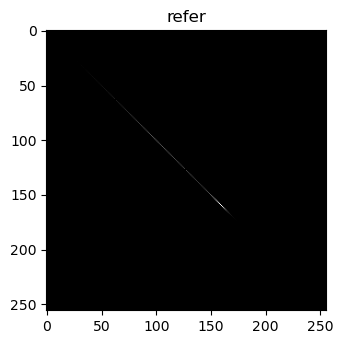

In [4]:
# Calculate the histogram of the images
hist_2d, _, _ = np.histogram2d(refered_img.ravel(), refered_img.ravel(), bins=256)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1), plt.imshow(hist_2d, cmap='gray'), plt.title('refer')

(<Axes: >, <BarContainer object of 256 artists>, (0.0, 256.0))

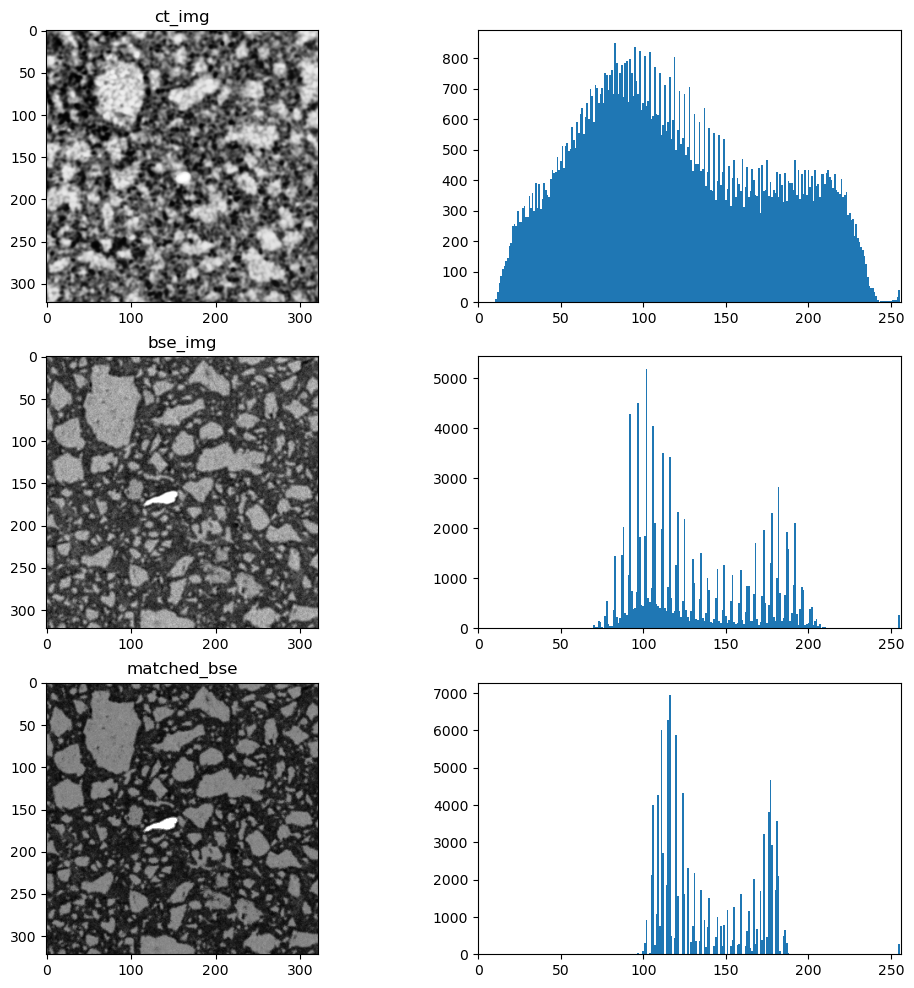

In [114]:
# 直方图匹配
# 直方图匹配算法：ref到ori的直方图匹配
def hist_matching(ori_img, ref_img):
    # 计算直方图
    hist_original = cv2.calcHist([ori_img], [0], None, [256], [0, 256]).ravel()
    hist_reference = cv2.calcHist([ref_img], [0], None, [256], [0, 256]).ravel()

    # 计算CDF
    cdf_original = hist_original.cumsum()
    cdf_reference = hist_reference.cumsum()

    # 归一化CDF
    cdf_original = (cdf_original / cdf_original[-1]).astype(np.float32)
    cdf_reference = (cdf_reference / cdf_reference[-1]).astype(np.float32)

    # 计算映射表
    M = np.zeros(256)
    for i in range(256):
        idx = np.abs(cdf_reference - cdf_original[i]).argmin()
        M[i] = idx

    # 应用映射
    matched_image = M[ref_img.flatten()].reshape(ref_img.shape).astype(np.uint8)
    return matched_image

# 读取ct图像，这个CT图像是经过对比度增强之后的图像
ct_img = cv2.imread('spatial-correlation-statistics/ct_mini.bmp', cv2.IMREAD_GRAYSCALE)
# 读取bse图像，这个图像也是经过对比度增强之后的图像
bse_img = cv2.imread('spatial-correlation-statistics/bse_mini.bmp', cv2.IMREAD_GRAYSCALE)

ct_hist = cv2.calcHist([ct_img], [0], None, [256], [0, 256])
bse_hist = cv2.calcHist([bse_img], [0], None, [256], [0, 256])

# 把bse图像作为待匹配图像，ct图像的直方图作为目标直方图进行匹配
matched_bse = hist_matching(ct_img, bse_img)
matched_bse_hist = cv2.calcHist([matched_bse], [0], None, [256], [0, 256])

# 显示图像
# 1. 源ct图像，         2. 源ct图像直方图
# 3. 源bse图像          4. 源bse图像直方图
# 5. 匹配后的bse图像    6. 匹配后bse图像直方图
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1), plt.imshow(ct_img, cmap='gray'), plt.title('ct_img')
plt.subplot(3, 2, 2), plt.bar(range(256), ct_hist.ravel(), width=1), plt.xlim([0, 256])
plt.subplot(3, 2, 3), plt.imshow(bse_img, cmap='gray'), plt.title('bse_img')
plt.subplot(3, 2, 4), plt.bar(range(256), bse_hist.ravel(), width=1), plt.xlim([0, 256])
plt.subplot(3, 2, 5), plt.imshow(matched_bse, cmap='gray'), plt.title('matched_bse')
plt.subplot(3, 2, 6), plt.bar(range(256), matched_bse_hist.ravel(), width=1), plt.xlim([0, 256])


